# Exploratory Data Analysis Notebook
This EDA Notebook explores the dataset and the training methods used to create a content classifier. It is based on the combined data entries from:
- Hugging Face (AG News & Rotten Tomatoes)
- Wikipedia
- ArXiv

covering the following topics:
- business
- entertainment
- health
- politics
- science
- sports
- technology

## 0: Init

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import defaultdict
from wordcloud import WordCloud

# warnings setting
warnings.filterwarnings('ignore')

# config viz
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [2]:
# load data
data_path = '../data/combined_dataset.csv'
df = pd.read_csv(data_path)

print("="*70)
print("DATASET LOADED SUCCESSFULLY")
print("="*70)

DATASET LOADED SUCCESSFULLY


In [3]:
# verify dataset
print("\n[1] Dataset Shape:")
print(f"    Total samples: {df.shape[0]:,}")
print(f"    Total features: {df.shape[1]}")

print("\n[2] Column Names:")
print(f"    {list(df.columns)}")

print("\n[3] Data Types:")
print(df.dtypes)

print("\n[4] Missing Values:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("    ✓ No missing values found")
else:
    print(missing[missing > 0])

print("\n[5] First Few Rows:")
print(df.head(3))


[1] Dataset Shape:
    Total samples: 80,159
    Total features: 3

[2] Column Names:
    ['content', 'unified_topic', 'source']

[3] Data Types:
content          object
unified_topic    object
source           object
dtype: object

[4] Missing Values:
    ✓ No missing values found

[5] First Few Rows:
                                             content unified_topic source
0  Essbase 7X brings interactive BI to BPM For so...      Business   news
1  Investment curbs working, Beijing says BEIJING...      Business   news
2  Nextel Said to Be in Talks With Sprint The cel...      Business   news


## 1: Dataset Overview

In [4]:
# quick analytics of the dataset

# output header
print("\n" + "="*70)
print("DATASET OVERVIEW STATISTICS")
print("="*70)


# topic distribution
topic_counts = df['unified_topic'].value_counts().sort_index()
topic_percentages = (topic_counts / len(df) * 100).round(2)


# source distribution
source_counts = df['source'].value_counts().sort_index()
source_percentages = (source_counts / len(df) * 100).round(2)


# create combined distribution table
print("\n[1] Distribution Matrix:")
print("\nTOPIC DISTRIBUTION:")
topic_df = pd.DataFrame({
    'Topic': topic_counts.index,
    'Count': topic_counts.values,
    'Percentage': [f"{p:.2f}%" for p in topic_percentages.values]
})
print(topic_df.to_string(index=False))
print(f"\nTotal topics: {df['unified_topic'].nunique()}")

print("\n" + "-"*50)

print("\nSOURCE DISTRIBUTION:")
source_df = pd.DataFrame({
    'Source': source_counts.index,
    'Count': source_counts.values,
    'Percentage': [f"{p:.2f}%" for p in source_percentages.values]
})
print(source_df.to_string(index=False))
print(f"\nTotal sources: {df['source'].nunique()}")


# class imbalance metrics
print("\n[2] Class Imbalance Analysis:")
max_class = topic_counts.max()
min_class = topic_counts.min()
imbalance_ratio = max_class / min_class

print(f"    Largest class: {topic_counts.idxmax()} ({max_class:,} samples)")
print(f"    Smallest class: {topic_counts.idxmin()} ({min_class:,} samples)")
print(f"    Imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio < 3:
    balance_status = "✓ Acceptable (< 3:1)"
elif imbalance_ratio < 5:
    balance_status = "⚠ Moderate (3-5:1)"
else:
    balance_status = "✗ High (> 5:1)"

print(f"    Status: {balance_status}")


DATASET OVERVIEW STATISTICS

[1] Distribution Matrix:

TOPIC DISTRIBUTION:
        Topic  Count Percentage
     Business  12411     15.48%
Entertainment  15278     19.06%
       Health   7707      9.61%
     Politics  11027     13.76%
      Science   6389      7.97%
       Sports  10932     13.64%
   Technology  16415     20.48%

Total topics: 7

--------------------------------------------------

SOURCE DISTRIBUTION:
       Source  Count Percentage
 encyclopedia  20014     24.97%
entertainment   9525     11.88%
   literature   7071      8.82%
         news  32000     39.92%
   scientific  11549     14.41%

Total sources: 5

[2] Class Imbalance Analysis:
    Largest class: Technology (16,415 samples)
    Smallest class: Science (6,389 samples)
    Imbalance ratio: 2.57:1
    Status: ✓ Acceptable (< 3:1)


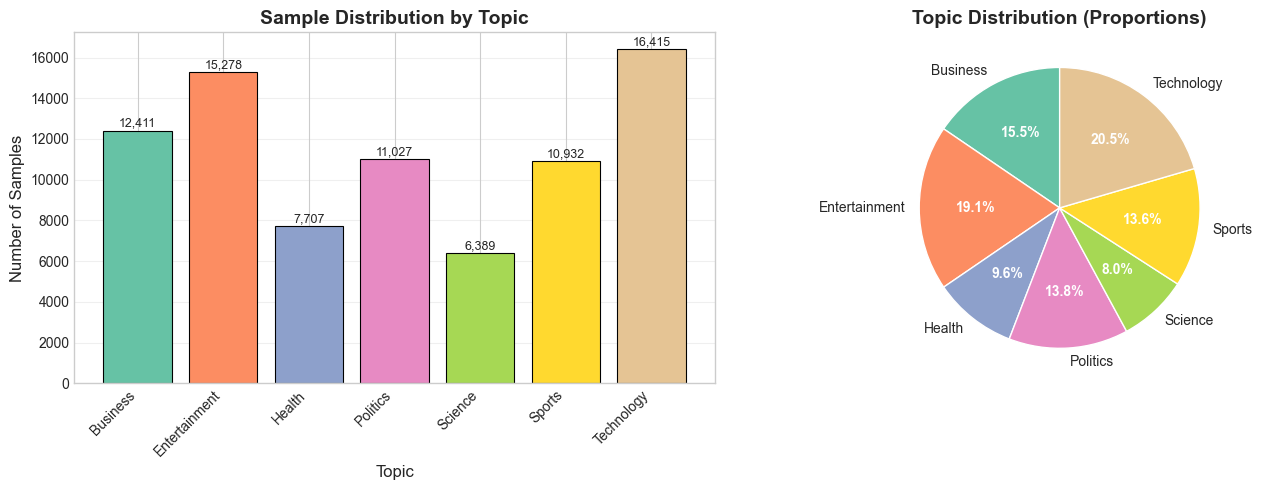


✓ Topic distribution visualizations saved


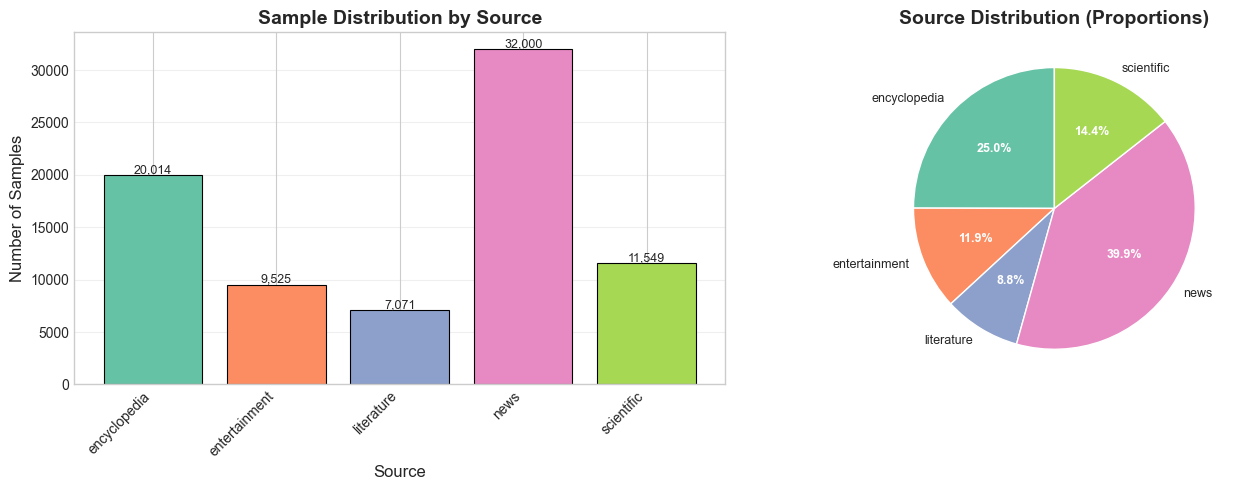

✓ Source distribution visualizations saved


In [5]:
# visualization of dataset source and topic distribution

# topic distribution
# ColorBrewer 'Set2' palette + graph config
topic_colors = sns.color_palette('Set2', n_colors=len(topic_counts))
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


# bar chart: samples per topic
ax1 = axes[0]
bars = ax1.bar(range(len(topic_counts)), topic_counts.values,
               color=topic_colors, edgecolor='black', linewidth=0.8)
ax1.set_xticks(range(len(topic_counts)))
ax1.set_xticklabels(topic_counts.index, rotation=45, ha='right')
ax1.set_title('Sample Distribution by Topic', fontsize=14, fontweight='bold')
ax1.set_xlabel('Topic', fontsize=12)
ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.grid(axis='y', alpha=0.3)


# add count labels on bars
for i, count in enumerate(topic_counts.values):
    ax1.text(i, count + 200, f'{count:,}', ha='center', fontsize=9)

# pie chart: topic proportions
ax2 = axes[1]
wedges, texts, autotexts = ax2.pie(
    topic_counts,
    labels=topic_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=topic_colors,
    textprops={'fontsize': 10}
)

ax2.set_title('Topic Distribution (Proportions)', fontsize=14, fontweight='bold')


# make percentage text bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')


# output viz
plt.tight_layout()
plt.savefig('../results/01_dataset/01_topic_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Topic distribution visualizations saved")



# source distribution
# ColorBrewer 'Set2' palette + graph config
source_colors = sns.color_palette('Set2', n_colors=len(source_counts))
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


# bar chart: samples per source
ax1 = axes[0]
bars = ax1.bar(range(len(source_counts)), source_counts.values,
               color=source_colors, edgecolor='black', linewidth=0.8)
ax1.set_xticks(range(len(source_counts)))
ax1.set_xticklabels(source_counts.index, rotation=45, ha='right')
ax1.set_title('Sample Distribution by Source', fontsize=14, fontweight='bold')
ax1.set_xlabel('Source', fontsize=12)
ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.grid(axis='y', alpha=0.3)


# add count labels on bars
for i, count in enumerate(source_counts.values):
    ax1.text(i, count + 200, f'{count:,}', ha='center', fontsize=9)


# pie chart: source proportions
ax2 = axes[1]
wedges, texts, autotexts = ax2.pie(
    source_counts,
    labels=source_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=source_colors,
    textprops={'fontsize': 9}
)

ax2.set_title('Source Distribution (Proportions)', fontsize=14, fontweight='bold')


# make percentage text bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')


# output viz
plt.tight_layout()
plt.savefig('../results/01_dataset/02_source_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Source distribution visualizations saved")

In [6]:
# summary

print("\n" + "="*70)
print("SUMMARY")
print("="*70)

summary_data = {
    'Metric': [
        'Total Samples',
        'Number of Topics',
        'Number of Sources',
        'Most Common Topic',
        'Least Common Topic',
        'Imbalance Ratio'
    ],
    'Value': [
        f"{len(df):,}",
        df['unified_topic'].nunique(),
        df['source'].nunique(),
        f"{topic_counts.idxmax()} ({max_class:,})",
        f"{topic_counts.idxmin()} ({min_class:,})",
        f"{imbalance_ratio:.2f}:1"
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


SUMMARY
            Metric               Value
     Total Samples              80,159
  Number of Topics                   7
 Number of Sources                   5
 Most Common Topic Technology (16,415)
Least Common Topic     Science (6,389)
   Imbalance Ratio              2.57:1


## 2: Cross-Tabulation Analysis

In [7]:
# cross-tabulation calculations

# header
print("\n" + "="*70)
print("CROSS-TABULATION ANALYSIS: TOPIC × SOURCE")
print("="*70)

# cross-tabulation matrix
crosstab = pd.crosstab(
    df['unified_topic'],
    df['source'],
    margins=True,
    margins_name='Total'
)

print("\n[1] Topic × Source Matrix (Sample Counts):")
print(crosstab)


# identify coverage gaps (combinations with 0 samples)
crosstab_no_margins = pd.crosstab(df['unified_topic'], df['source'])
zero_combinations = []

for topic in crosstab_no_margins.index:
    for source in crosstab_no_margins.columns:
        if crosstab_no_margins.loc[topic, source] == 0:
            zero_combinations.append(f"{topic} × {source}")

print(f"\n[2] Coverage Analysis:")
total_combinations = len(crosstab_no_margins.index) * len(crosstab_no_margins.columns)
filled_combinations = total_combinations - len(zero_combinations)
coverage_pct = (filled_combinations / total_combinations * 100)

print(f"    Total possible combinations: {total_combinations}")
print(f"    Filled combinations: {filled_combinations}")
print(f"    Coverage: {coverage_pct:.1f}%")

if len(zero_combinations) > 0:
    print(f"\n    ⚠ Missing combinations ({len(zero_combinations)}):")
    for combo in zero_combinations:
        print(f"       - {combo}")
else:
    print("\n    ✓ Complete coverage - all combinations present")


# find min/max combinations
crosstab_flat = crosstab_no_margins.stack().reset_index()
crosstab_flat.columns = ['Topic', 'Source', 'Count']
crosstab_flat = crosstab_flat.sort_values('Count', ascending=False)

print(f"\n[3] Extreme Combinations:")
print(f"    Most samples: {crosstab_flat.iloc[0]['Topic']} × {crosstab_flat.iloc[0]['Source']} ({crosstab_flat.iloc[0]['Count']:,})")
print(f"    Least samples: {crosstab_flat.iloc[-1]['Topic']} × {crosstab_flat.iloc[-1]['Source']} ({crosstab_flat.iloc[-1]['Count']:,})")


CROSS-TABULATION ANALYSIS: TOPIC × SOURCE

[1] Topic × Source Matrix (Sample Counts):
source         encyclopedia  entertainment  literature   news  scientific  \
unified_topic                                                               
Business               2891              0          20   8000        1500   
Entertainment          2918           9525        2835      0           0   
Health                 2726              0          26      0        4955   
Politics               2858              0         169   8000           0   
Science                2874              0          15      0        3500   
Sports                 2926              0           6   8000           0   
Technology             2821              0        4000   8000        1594   
Total                 20014           9525        7071  32000       11549   

source         Total  
unified_topic         
Business       12411  
Entertainment  15278  
Health          7707  
Politics       11027  
Scie

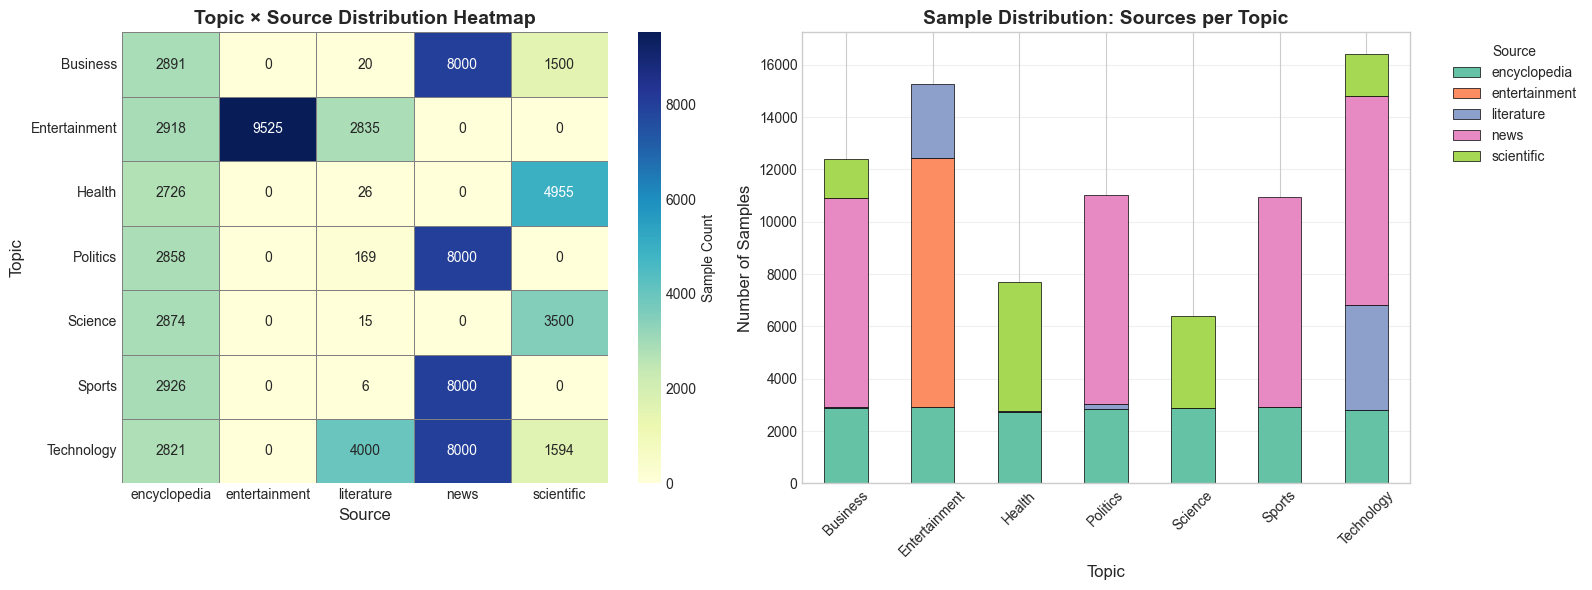


✓ Cross-tabulation visualizations saved


In [8]:
# visualization of cross-tabulation analysis

# graph config
fig, axes = plt.subplots(1, 2, figsize=(16, 6))


# heatmap: topic × source counts
ax1 = axes[0]
sns.heatmap(
    crosstab_no_margins,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Sample Count'},
    ax=ax1
)
ax1.set_title('Topic × Source Distribution Heatmap', fontsize=14, fontweight='bold')
ax1.set_xlabel('Source', fontsize=12)
ax1.set_ylabel('Topic', fontsize=12)


# stacked bar chart: sources per topic
ax2 = axes[1]
crosstab_no_margins.plot(
    kind='bar',
    stacked=True,
    ax=ax2,
    color=sns.color_palette('Set2', n_colors=len(crosstab_no_margins.columns)),
    edgecolor='black',
    linewidth=0.5
)
ax2.set_title('Sample Distribution: Sources per Topic', fontsize=14, fontweight='bold')
ax2.set_xlabel('Topic', fontsize=12)
ax2.set_ylabel('Number of Samples', fontsize=12)
ax2.legend(title='Source', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/01_dataset/03_crosstab_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Cross-tabulation visualizations saved")

## 3: Text Length Analysis

In [9]:
# text length calculations

# header
print("\n" + "="*70)
print("TEXT LENGTH ANALYSIS")
print("="*70)


# calculate word counts for each document
df['word_count'] = df['content'].str.split().str.len()


# overall statistics
print("\n[1] Overall Text Length Statistics (words per document):")
stats = df['word_count'].describe()
print(f"    Count:      {stats['count']:,.0f}")
print(f"    Mean:       {stats['mean']:.1f}")
print(f"    Std Dev:    {stats['std']:.1f}")
print(f"    Min:        {stats['min']:.0f}")
print(f"    25th %ile:  {stats['25%']:.0f}")
print(f"    Median:     {stats['50%']:.0f}")
print(f"    75th %ile:  {stats['75%']:.0f}")
print(f"    Max:        {stats['max']:.0f}")


# statistics by topic
print("\n[2] Text Length by Topic:")
topic_lengths = df.groupby('unified_topic')['word_count'].agg(['mean', 'median', 'std', 'min', 'max'])
topic_lengths = topic_lengths.round(1)
topic_lengths.columns = ['Mean', 'Median', 'Std Dev', 'Min', 'Max']
print(topic_lengths)


# identify topics with shortest and longest texts
shortest_topic = topic_lengths['Mean'].idxmin()
longest_topic = topic_lengths['Mean'].idxmax()
print(f"\n    Shortest texts (avg): {shortest_topic} ({topic_lengths.loc[shortest_topic, 'Mean']:.1f} words)")
print(f"    Longest texts (avg):  {longest_topic} ({topic_lengths.loc[longest_topic, 'Mean']:.1f} words)")


# statistics by source
print("\n[3] Text Length by Source:")
source_lengths = df.groupby('source')['word_count'].agg(['mean', 'median', 'std', 'min', 'max'])
source_lengths = source_lengths.round(1)
source_lengths.columns = ['Mean', 'Median', 'Std Dev', 'Min', 'Max']
print(source_lengths)


# identify sources with shortest and longest texts
shortest_source = source_lengths['Mean'].idxmin()
longest_source = source_lengths['Mean'].idxmax()
print(f"\n    Shortest texts (avg): {shortest_source} ({source_lengths.loc[shortest_source, 'Mean']:.1f} words)")
print(f"    Longest texts (avg):  {longest_source} ({source_lengths.loc[longest_source, 'Mean']:.1f} words)")


# identify outliers (using IQR method)
Q1 = df['word_count'].quantile(0.25)
Q3 = df['word_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['word_count'] < lower_bound) | (df['word_count'] > upper_bound)]
outlier_pct = (len(outliers) / len(df) * 100)


# output
print(f"\n[4] Outlier Detection (IQR method):")
print(f"    Lower bound: {lower_bound:.0f} words")
print(f"    Upper bound: {upper_bound:.0f} words")
print(f"    Outliers found: {len(outliers):,} ({outlier_pct:.2f}%)")
print(f"    Outliers too short: {len(outliers[outliers['word_count'] < lower_bound]):,}")
print(f"    Outliers too long: {len(outliers[outliers['word_count'] > upper_bound]):,}")


TEXT LENGTH ANALYSIS

[1] Overall Text Length Statistics (words per document):
    Count:      80,159
    Mean:       117.3
    Std Dev:    168.6
    Min:        6
    25th %ile:  33
    Median:     45
    75th %ile:  153
    Max:        1829

[2] Text Length by Topic:
                Mean  Median  Std Dev  Min   Max
unified_topic                                   
Business        76.5    42.0     81.3    8  1402
Entertainment  114.3    29.0    217.9    6  1829
Health         174.4   171.0     86.4    6   923
Politics        76.2    41.0    105.9    8  1584
Science        174.6   170.0     97.1    8   980
Sports          65.4    39.0     82.5    8  1013
Technology     163.8    51.0    247.6    7  1732

    Shortest texts (avg): Sports (65.4 words)
    Longest texts (avg):  Science (174.6 words)

[3] Text Length by Source:
                Mean  Median  Std Dev  Min   Max
source                                          
encyclopedia   148.1   110.0    123.9    7  1001
entertainment   22

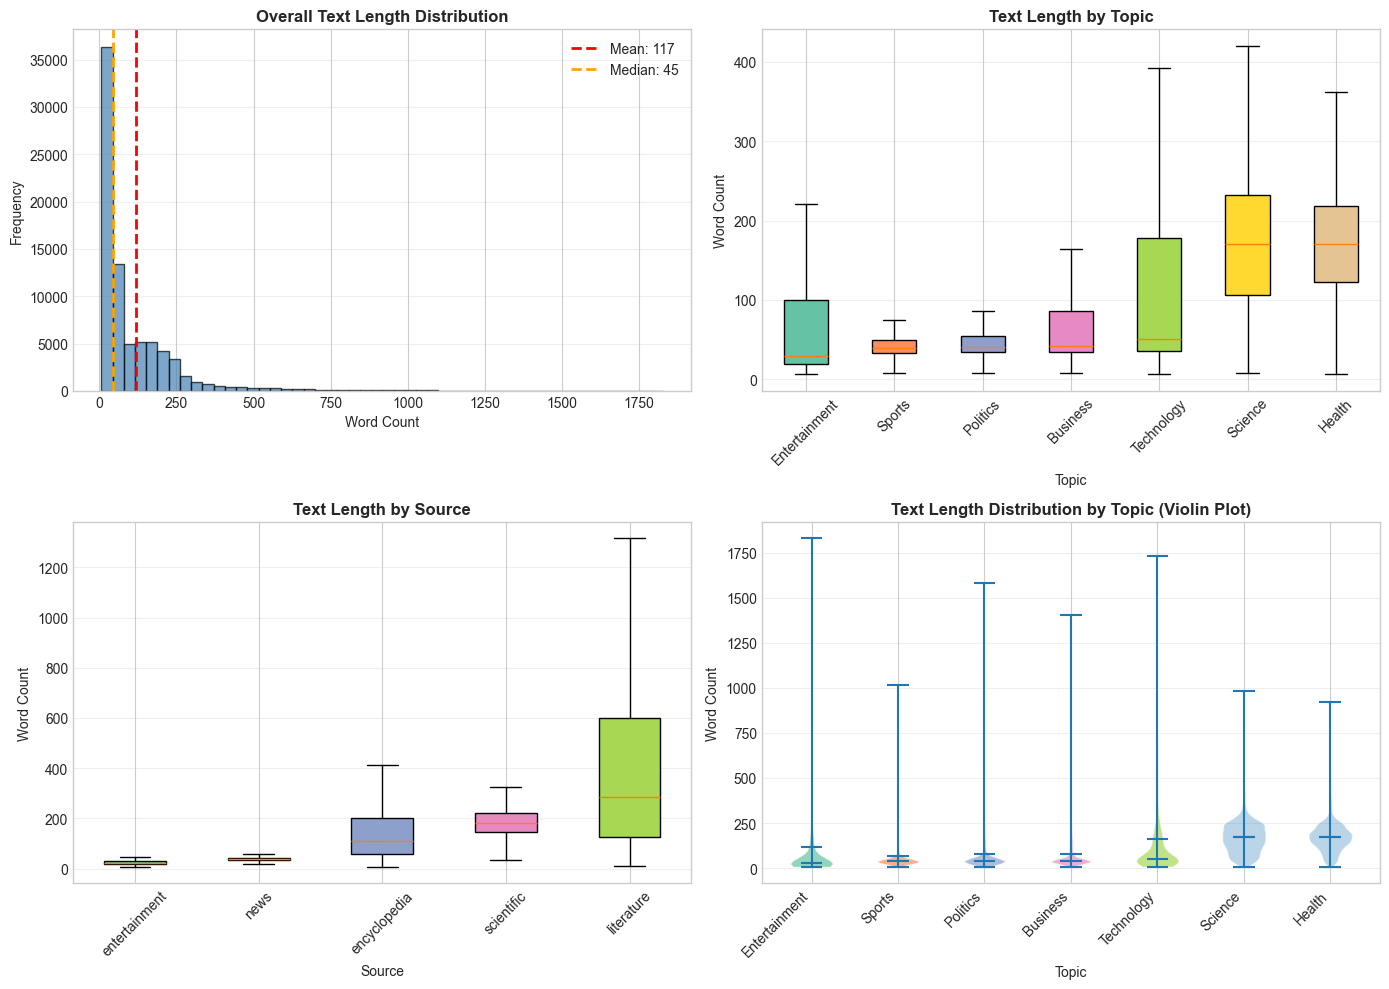


✓ Text length visualizations saved


In [10]:
# visualization of text length analysis

# graph config
fig, axes = plt.subplots(2, 2, figsize=(14, 10))


# overall distribution histogram
ax1 = axes[0, 0]
ax1.hist(df['word_count'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(df['word_count'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['word_count'].mean():.0f}")
ax1.axvline(df['word_count'].median(), color='orange', linestyle='--', linewidth=2, label=f"Median: {df['word_count'].median():.0f}")
ax1.set_title('Overall Text Length Distribution', fontsize=12, fontweight='bold')
ax1.set_xlabel('Word Count', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)


# boxplot by topic
ax2 = axes[0, 1]
topic_order = df.groupby('unified_topic')['word_count'].median().sort_values().index
df_sorted = df.set_index('unified_topic').loc[topic_order].reset_index()
colors = sns.color_palette('Set2', n_colors=len(topic_order))
bp = ax2.boxplot(
    [df[df['unified_topic'] == topic]['word_count'] for topic in topic_order],
    labels=topic_order,
    patch_artist=True,
    showfliers=False
)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')

ax2.set_title('Text Length by Topic', fontsize=12, fontweight='bold')
ax2.set_xlabel('Topic', fontsize=10)
ax2.set_ylabel('Word Count', fontsize=10)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)


# boxplot by source
ax3 = axes[1, 0]
source_order = df.groupby('source')['word_count'].median().sort_values().index
colors = sns.color_palette('Set2', n_colors=len(source_order))
bp = ax3.boxplot(
    [df[df['source'] == source]['word_count'] for source in source_order],
    labels=source_order,
    patch_artist=True,
    showfliers=False
)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')

ax3.set_title('Text Length by Source', fontsize=12, fontweight='bold')
ax3.set_xlabel('Source', fontsize=10)
ax3.set_ylabel('Word Count', fontsize=10)
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)


# violin plot (alternative view)
ax4 = axes[1, 1]
parts = ax4.violinplot(
    [df[df['unified_topic'] == topic]['word_count'] for topic in topic_order],
    positions=range(len(topic_order)),
    showmeans=True,
    showmedians=True
)

for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

ax4.set_xticks(range(len(topic_order)))
ax4.set_xticklabels(topic_order, rotation=45, ha='right')
ax4.set_title('Text Length Distribution by Topic (Violin Plot)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Topic', fontsize=10)
ax4.set_ylabel('Word Count', fontsize=10)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/01_dataset/04_text_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Text length visualizations saved")

## 4: Vocabulary Analysis

In [11]:
# vocabulary calculations

# header
print("\n" + "="*70)
print("VOCABULARY ANALYSIS")
print("="*70)


# text preprocessing function for vocabulary analysis

# extract words from text (lowercase, remove punctuation)
def extract_words(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    return words

# extract words and remove stopwords
def extract_words_clean(text):
    words = extract_words(text)
    # filter out stopwords
    words_clean = [w for w in words if w not in ENGLISH_STOP_WORDS and len(w) > 2]
    return words_clean


# calculate vocabulary
print("\n[1] Overall Vocabulary Statistics:")
all_words = []
for text in df['content']:
    all_words.extend(extract_words(text))

unique_words = set(all_words)
total_words = len(all_words)
vocab_size = len(unique_words)

print(f"    Total words: {total_words:,}")
print(f"    Unique words (vocabulary size): {vocab_size:,}")
print(f"    Vocabulary richness: {(vocab_size/total_words)*100:.2f}%")


# most common words
word_freq = Counter(all_words)
top_20_words = word_freq.most_common(20)

print(f"\n[2] Top 20 Most Common Words (Overall):")
for rank, (word, count) in enumerate(top_20_words, 1):
    pct = (count / total_words) * 100
    print(f"    {rank:>2}. {word:<15} {count:>8,} ({pct:>5.2f}%)")


# vocabulary size by topic
print("\n[3] Vocabulary Size by Topic:")
topic_vocab = {}
topic_word_counts = {}

for topic in df['unified_topic'].unique():
    topic_texts = df[df['unified_topic'] == topic]['content']
    topic_words = []
    for text in topic_texts:
        topic_words.extend(extract_words(text))

    topic_vocab[topic] = len(set(topic_words))
    topic_word_counts[topic] = len(topic_words)

vocab_df = pd.DataFrame({
    'Topic': list(topic_vocab.keys()),
    'Vocab Size': list(topic_vocab.values()),
    'Total Words': list(topic_word_counts.values()),
    'Richness %': [(topic_vocab[t]/topic_word_counts[t])*100 for t in topic_vocab.keys()]
}).sort_values('Vocab Size', ascending=False)

vocab_df['Richness %'] = vocab_df['Richness %'].round(2)
print(vocab_df.to_string(index=False))


# vocabulary size by source
print("\n[4] Vocabulary Size by Source:")
source_vocab = {}
source_word_counts = {}

for source in df['source'].unique():
    source_texts = df[df['source'] == source]['content']
    source_words = []
    for text in source_texts:
        source_words.extend(extract_words(text))

    source_vocab[source] = len(set(source_words))
    source_word_counts[source] = len(source_words)

source_vocab_df = pd.DataFrame({
    'Source': list(source_vocab.keys()),
    'Vocab Size': list(source_vocab.values()),
    'Total Words': list(source_word_counts.values()),
    'Richness %': [(source_vocab[s]/source_word_counts[s])*100 for s in source_vocab.keys()]
}).sort_values('Vocab Size', ascending=False)

source_vocab_df['Richness %'] = source_vocab_df['Richness %'].round(2)
print(source_vocab_df.to_string(index=False))


VOCABULARY ANALYSIS

[1] Overall Vocabulary Statistics:
    Total words: 9,219,412
    Unique words (vocabulary size): 214,025
    Vocabulary richness: 2.32%

[2] Top 20 Most Common Words (Overall):
     1. the              585,082 ( 6.35%)
     2. and              290,749 ( 3.15%)
     3. of               290,403 ( 3.15%)
     4. to               238,272 ( 2.58%)
     5. a                222,599 ( 2.41%)
     6. in               203,813 ( 2.21%)
     7. is               120,681 ( 1.31%)
     8. for               82,676 ( 0.90%)
     9. that              81,409 ( 0.88%)
    10. as                74,598 ( 0.81%)
    11. with              73,479 ( 0.80%)
    12. on                66,999 ( 0.73%)
    13. by                66,964 ( 0.73%)
    14. from              44,512 ( 0.48%)
    15. are               43,127 ( 0.47%)
    16. his               42,638 ( 0.46%)
    17. an                41,675 ( 0.45%)
    18. he                40,866 ( 0.44%)
    19. it                40,699 ( 0.44%)
  

There are a **lot** of stop words. The plan is to clean them out in a later step while using ngrams, embeddings, etc. but for an initial check of the data set we are doing a high-level cleaning in this notebook already.

In [12]:
# cleaned vocabulary calculations (no stopwords)

# header
print("\n" + "="*70)
print("VOCABULARY ANALYSIS (CLEANED)")
print("="*70)


# calculate cleaned vocabulary
print("\n[1] Overall Vocabulary Statistics (Cleaned):")
all_words_clean = []
for text in df['content']:
    all_words_clean.extend(extract_words(text))

unique_words_clean = set(all_words_clean)
total_words_clean = len(all_words_clean)
vocab_size_clean = len(unique_words_clean)

print(f"    Total words (after cleaning): {total_words_clean:,}")
print(f"    Unique words (vocabulary size): {vocab_size_clean:,}")
print(f"    Vocabulary richness: {(vocab_size_clean/total_words_clean)*100:.2f}%")

print(f"\n    Impact of cleaning:")
print(f"    • Words removed: {total_words - total_words_clean:,} ({((total_words - total_words_clean)/total_words)*100:.1f}%)")
print(f"    • Vocab reduction: {vocab_size - vocab_size_clean:,} unique words")
print(f"    • Richness increase: +{((vocab_size_clean/total_words_clean) - (vocab_size/total_words))*100:.2f}%")


# most common cleaned words
word_freq_clean = Counter(all_words_clean)
top_20_words_clean = word_freq_clean.most_common(20)

print(f"\n[2] Top 20 Most Common Content Words (Cleaned):")
for rank, (word, count) in enumerate(top_20_words_clean, 1):
    pct = (count / total_words_clean) * 100
    print(f"    {rank:>2}. {word:<15} {count:>8,} ({pct:>5.2f}%)")


# cleaned vocabulary size by topic
print("\n[3] Vocabulary Size by Topic (Cleaned):")
topic_vocab_clean = {}
topic_word_counts_clean = {}

for topic in df['unified_topic'].unique():
    topic_texts = df[df['unified_topic'] == topic]['content']
    topic_words = []
    for text in topic_texts:
        topic_words.extend(extract_words(text))

    topic_vocab_clean[topic] = len(set(topic_words))
    topic_word_counts_clean[topic] = len(topic_words)

vocab_df_clean = pd.DataFrame({
    'Topic': list(topic_vocab_clean.keys()),
    'Vocab Size': list(topic_vocab_clean.values()),
    'Total Words': list(topic_word_counts_clean.values()),
    'Richness %': [(topic_vocab_clean[t]/topic_word_counts_clean[t])*100 for t in topic_vocab_clean.keys()]
}).sort_values('Vocab Size', ascending=False)

vocab_df_clean['Richness %'] = vocab_df_clean['Richness %'].round(2)
print(vocab_df_clean.to_string(index=False))


# cleaned vocabulary size by source
print("\n[4] Vocabulary Size by Source (Cleaned):")
source_vocab_clean = {}
source_word_counts_clean = {}

for source in df['source'].unique():
    source_texts = df[df['source'] == source]['content']
    source_words = []
    for text in source_texts:
        source_words.extend(extract_words(text))

    source_vocab_clean[source] = len(set(source_words))
    source_word_counts_clean[source] = len(source_words)

source_vocab_df_clean = pd.DataFrame({
    'Source': list(source_vocab_clean.keys()),
    'Vocab Size': list(source_vocab_clean.values()),
    'Total Words': list(source_word_counts_clean.values()),
    'Richness %': [(source_vocab_clean[s]/source_word_counts_clean[s])*100 for s in source_vocab_clean.keys()]
}).sort_values('Vocab Size', ascending=False)

source_vocab_df_clean['Richness %'] = source_vocab_df_clean['Richness %'].round(2)
print(source_vocab_df_clean.to_string(index=False))


# top content words per topic
print("\n[5] Top 10 Content Words per Topic:")
topic_top_words_clean = {}

for topic in sorted(df['unified_topic'].unique()):
    topic_texts = df[df['unified_topic'] == topic]['content']
    topic_words = []
    for text in topic_texts:
        topic_words.extend(extract_words(text))

    topic_freq = Counter(topic_words)
    top_10 = topic_freq.most_common(10)
    topic_top_words_clean[topic] = top_10

    print(f"\n{topic}:")
    for rank, (word, count) in enumerate(top_10, 1):
        print(f"    {rank:>2}. {word:<15} {count:>6,}")


VOCABULARY ANALYSIS (CLEANED)

[1] Overall Vocabulary Statistics (Cleaned):
    Total words (after cleaning): 9,219,412
    Unique words (vocabulary size): 214,025
    Vocabulary richness: 2.32%

    Impact of cleaning:
    • Words removed: 0 (0.0%)
    • Vocab reduction: 0 unique words
    • Richness increase: +0.00%

[2] Top 20 Most Common Content Words (Cleaned):
     1. the              585,082 ( 6.35%)
     2. and              290,749 ( 3.15%)
     3. of               290,403 ( 3.15%)
     4. to               238,272 ( 2.58%)
     5. a                222,599 ( 2.41%)
     6. in               203,813 ( 2.21%)
     7. is               120,681 ( 1.31%)
     8. for               82,676 ( 0.90%)
     9. that              81,409 ( 0.88%)
    10. as                74,598 ( 0.81%)
    11. with              73,479 ( 0.80%)
    12. on                66,999 ( 0.73%)
    13. by                66,964 ( 0.73%)
    14. from              44,512 ( 0.48%)
    15. are               43,127 ( 0.47%)


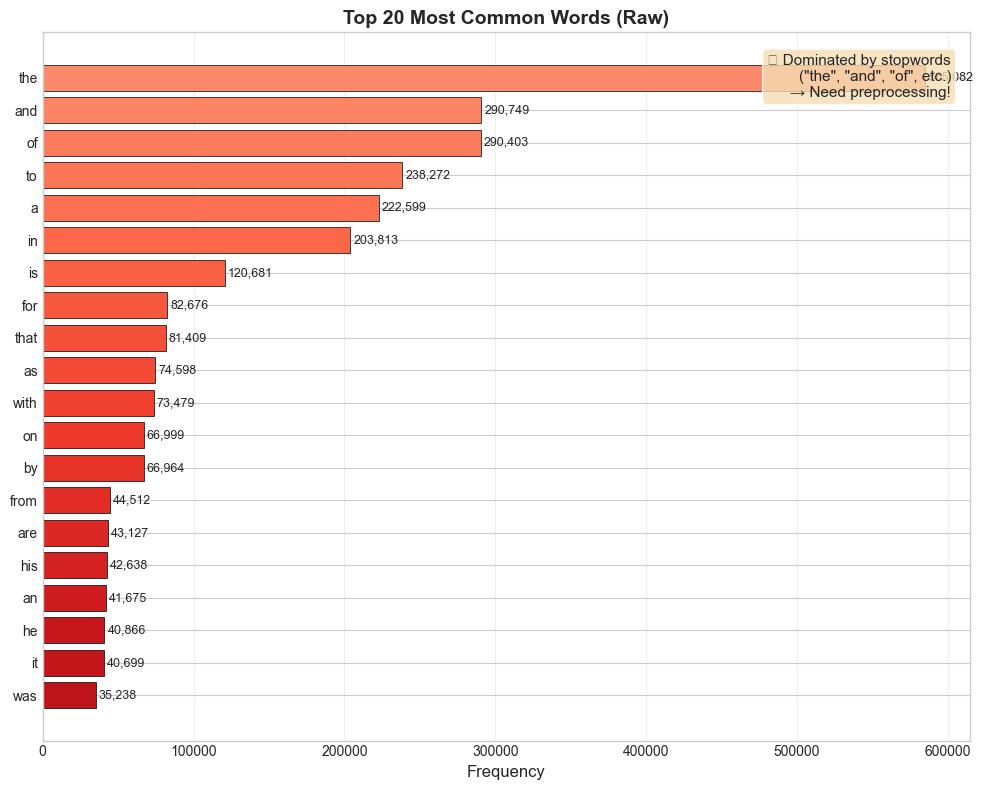


✓ Raw vocabulary visualization saved


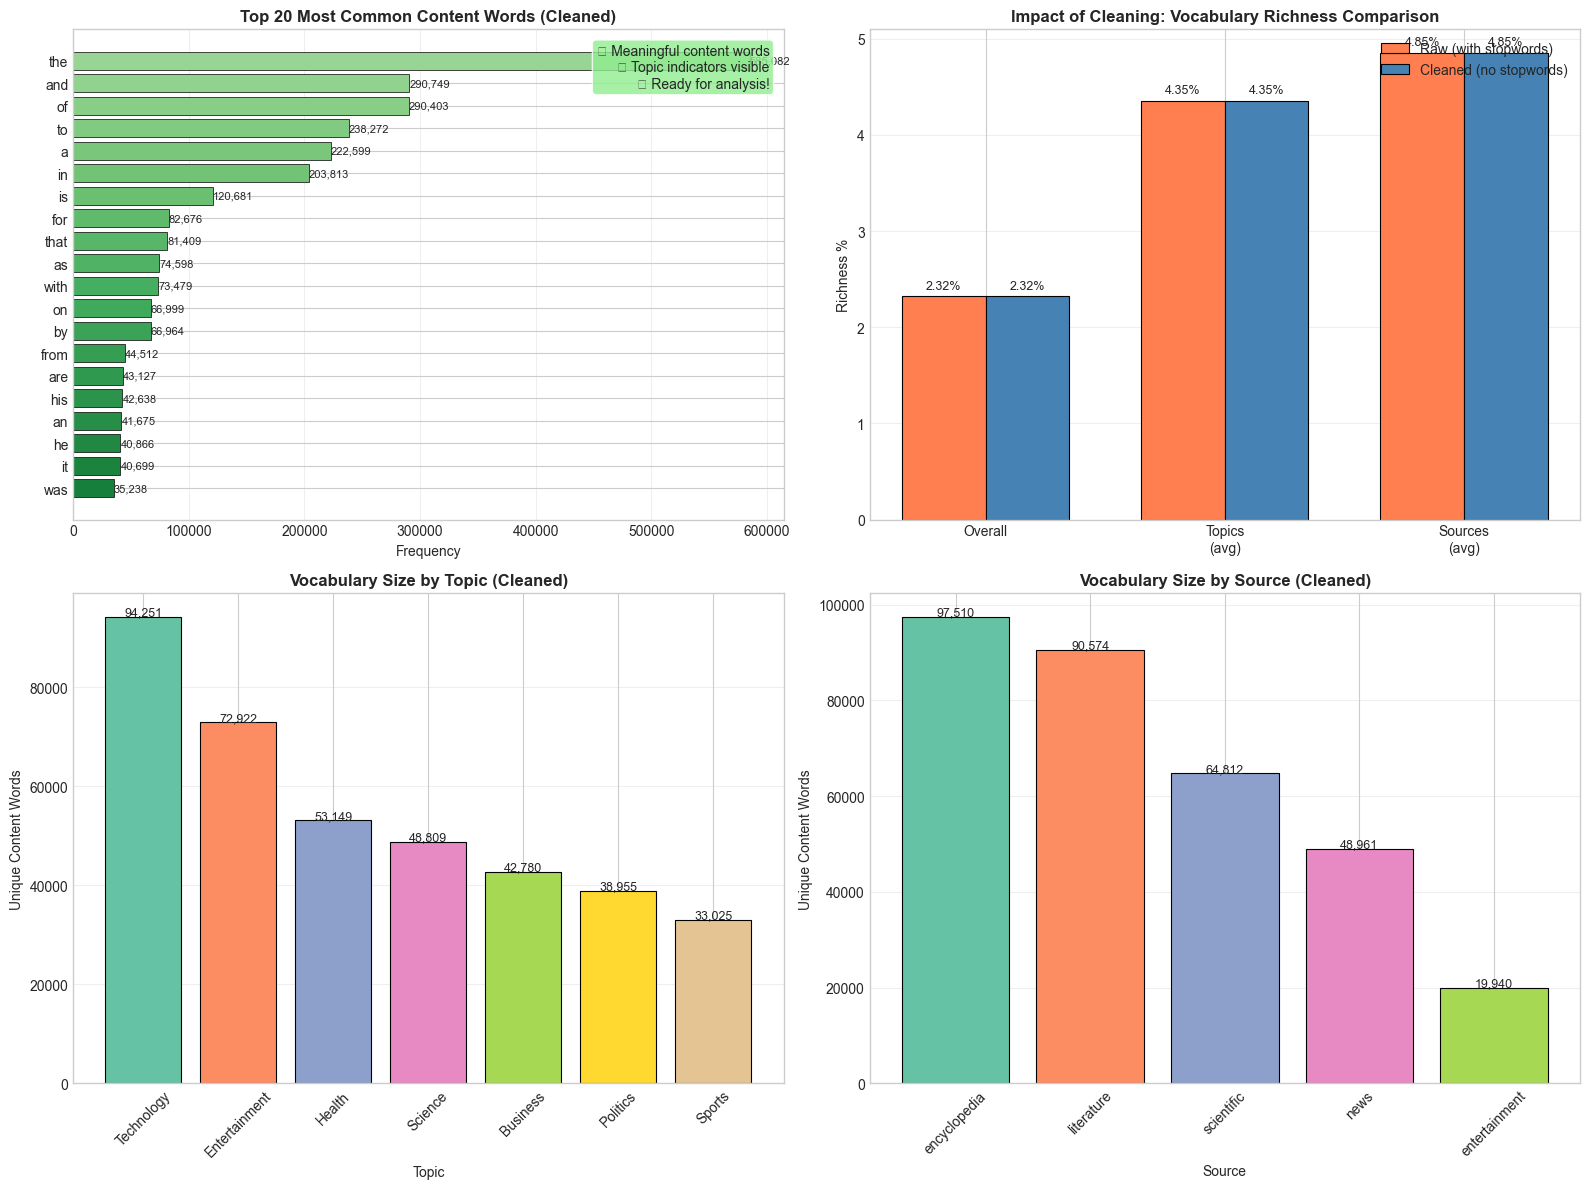


✓ Cleaned vocabulary visualizations saved


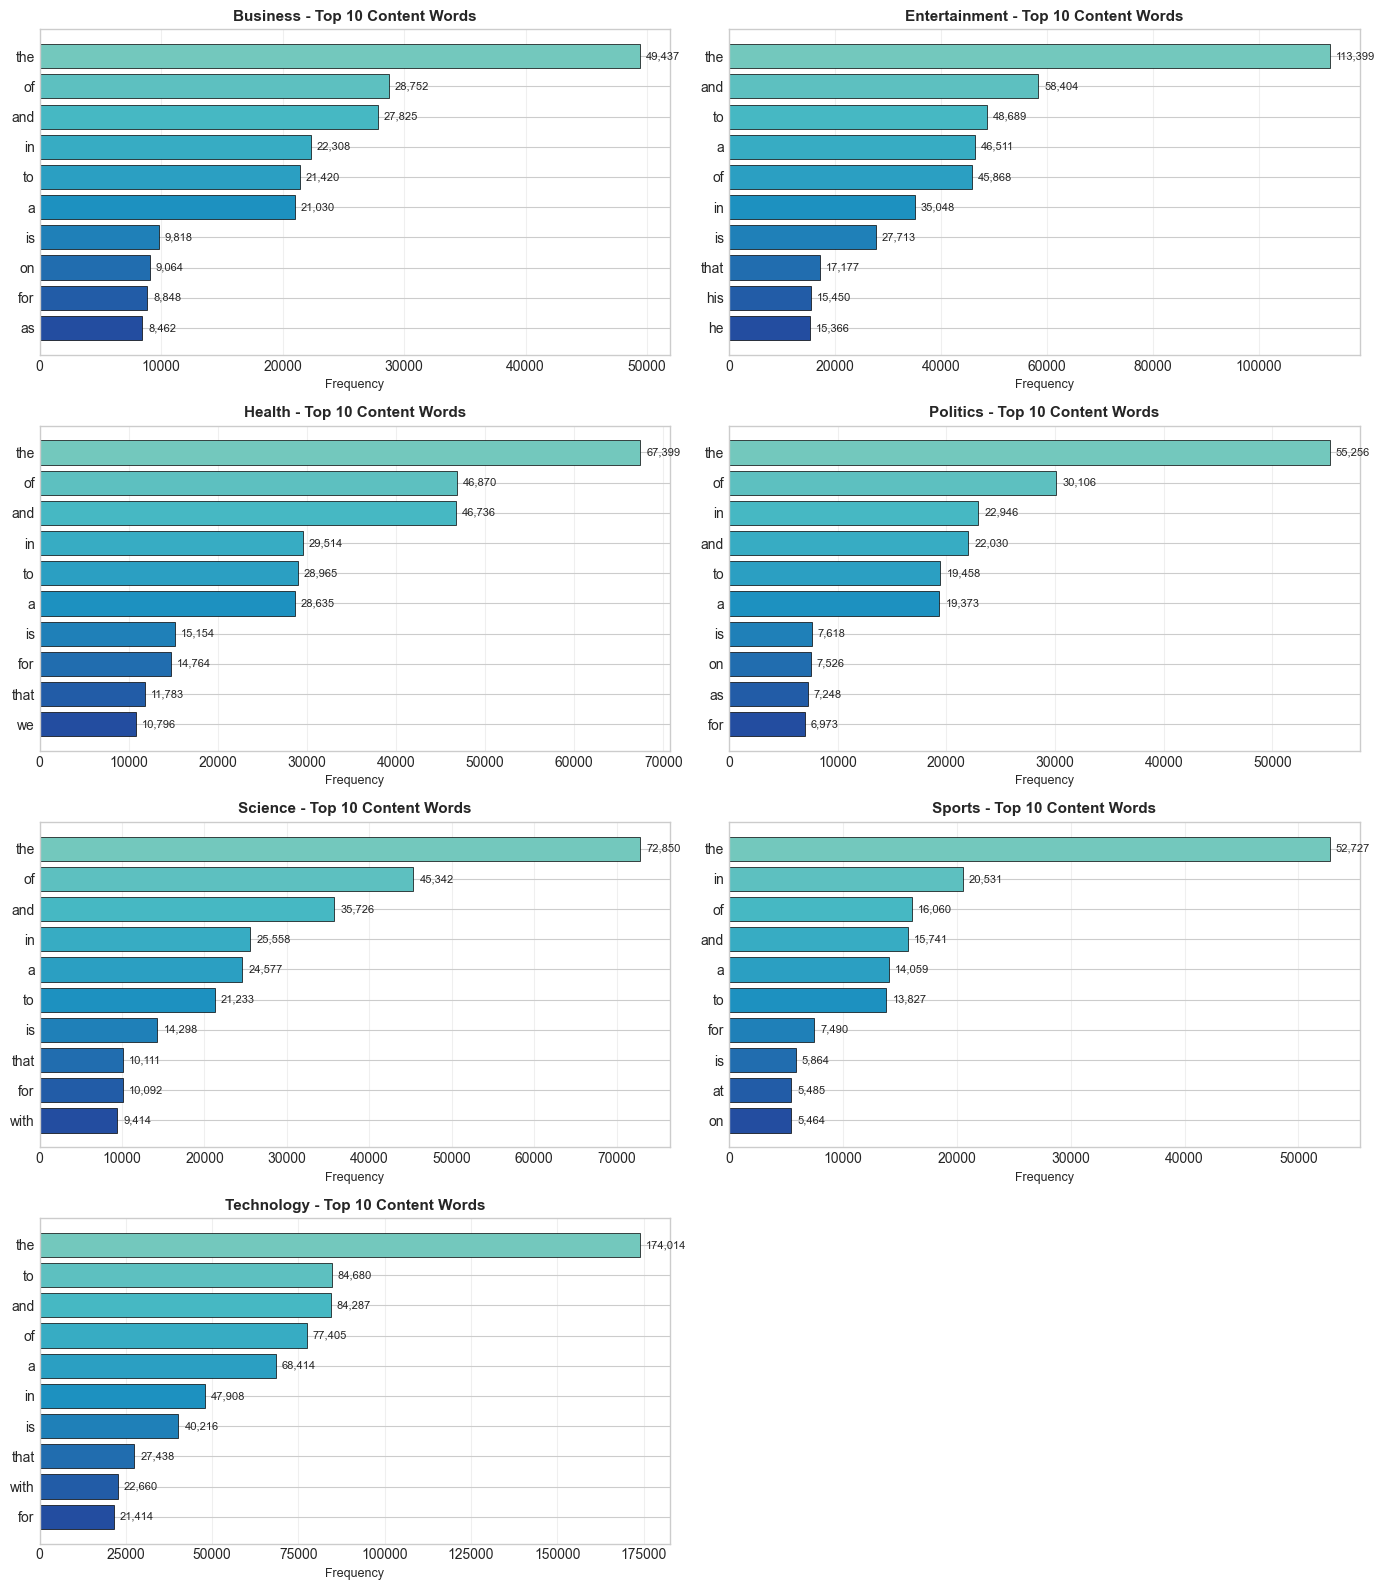


✓ Topic content word visualizations saved


In [13]:
# visualization vocabulary analysis

# visualization for raw data
# graph config
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

words, counts = zip(*top_20_words)
colors_gradient = plt.cm.Reds(np.linspace(0.4, 0.8, len(words)))
ax.barh(range(len(words)), counts, color=colors_gradient, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(words)))
ax.set_yticklabels(words)
ax.invert_yaxis()
ax.set_title('Top 20 Most Common Words (Raw)', fontsize=14, fontweight='bold')
ax.set_xlabel('Frequency', fontsize=12)
ax.grid(axis='x', alpha=0.3)

for i, count in enumerate(counts):
    ax.text(count + 2000, i, f'{count:,}', va='center', fontsize=9)


# annotation box
textstr = '⚠ Dominated by stopwords\n("the", "and", "of", etc.)\n→ Need preprocessing!'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.98, 0.97, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.savefig('../results/01_dataset/05_vocabulary_raw_problem.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Raw vocabulary visualization saved")



# visualization for vocabulary without stop words

# graph config
fig, axes = plt.subplots(2, 2, figsize=(16, 12))


# top 20 cleaned words
ax1 = axes[0, 0]
words_clean, counts_clean = zip(*top_20_words_clean)
colors_gradient = plt.cm.Greens(np.linspace(0.4, 0.8, len(words_clean)))
ax1.barh(range(len(words_clean)), counts_clean, color=colors_gradient, edgecolor='black', linewidth=0.5)
ax1.set_yticks(range(len(words_clean)))
ax1.set_yticklabels(words_clean)
ax1.invert_yaxis()
ax1.set_title('Top 20 Most Common Content Words (Cleaned)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Frequency', fontsize=10)
ax1.grid(axis='x', alpha=0.3)

for i, count in enumerate(counts_clean):
    ax1.text(count + 100, i, f'{count:,}', va='center', fontsize=8)


# add annotation
textstr = '✓ Meaningful content words\n✓ Topic indicators visible\n✓ Ready for analysis!'
props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.8)
ax1.text(0.98, 0.97, textstr, transform=ax1.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)


# comparison: raw vs cleaned richness
ax2 = axes[0, 1]

categories = ['Overall', 'Topics\n(avg)', 'Sources\n(avg)']


# calculate raw stats for comparison
topic_vocab_raw = {}
topic_word_counts_raw = {}
for topic in df['unified_topic'].unique():
    topic_texts = df[df['unified_topic'] == topic]['content']
    topic_words = []
    for text in topic_texts:
        topic_words.extend(extract_words(text))
    topic_vocab_raw[topic] = len(set(topic_words))
    topic_word_counts_raw[topic] = len(topic_words)

source_vocab_raw = {}
source_word_counts_raw = {}
for source in df['source'].unique():
    source_texts = df[df['source'] == source]['content']
    source_words = []
    for text in source_texts:
        source_words.extend(extract_words(text))
    source_vocab_raw[source] = len(set(source_words))
    source_word_counts_raw[source] = len(source_words)

raw_richness = [
    (vocab_size/total_words)*100,
    np.mean([(topic_vocab_raw[t]/topic_word_counts_raw[t])*100 for t in topic_vocab_raw]),
    np.mean([(source_vocab_raw[s]/source_word_counts_raw[s])*100 for s in source_vocab_raw])
]
clean_richness = [
    (vocab_size_clean/total_words_clean)*100,
    vocab_df_clean['Richness %'].mean(),
    source_vocab_df_clean['Richness %'].mean()
]

x = np.arange(len(categories))
width = 0.35

bars1 = ax2.bar(x - width/2, raw_richness, width, label='Raw (with stopwords)',
                color='coral', edgecolor='black', linewidth=0.8)
bars2 = ax2.bar(x + width/2, clean_richness, width, label='Cleaned (no stopwords)',
                color='steelblue', edgecolor='black', linewidth=0.8)

ax2.set_title('Impact of Cleaning: Vocabulary Richness Comparison', fontsize=12, fontweight='bold')
ax2.set_ylabel('Richness %', fontsize=10)
ax2.set_xticks(x)
ax2.set_xticklabels(categories)
ax2.legend(loc='upper right')
ax2.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{height:.2f}%', ha='center', va='bottom', fontsize=9)


# cleaned vocabulary size by topic
ax3 = axes[1, 0]
colors = sns.color_palette('Set2', n_colors=len(vocab_df_clean))
bars = ax3.bar(vocab_df_clean['Topic'], vocab_df_clean['Vocab Size'],
               color=colors, edgecolor='black', linewidth=0.8)
ax3.set_title('Vocabulary Size by Topic (Cleaned)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Topic', fontsize=10)
ax3.set_ylabel('Unique Content Words', fontsize=10)
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

for i, (topic, size) in enumerate(zip(vocab_df_clean['Topic'], vocab_df_clean['Vocab Size'])):
    ax3.text(i, size + 300, f'{size:,}', ha='center', fontsize=9)


# cleaned vocabulary size by source
ax4 = axes[1, 1]
colors = sns.color_palette('Set2', n_colors=len(source_vocab_df_clean))
bars = ax4.bar(source_vocab_df_clean['Source'], source_vocab_df_clean['Vocab Size'],
               color=colors, edgecolor='black', linewidth=0.8)
ax4.set_title('Vocabulary Size by Source (Cleaned)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Source', fontsize=10)
ax4.set_ylabel('Unique Content Words', fontsize=10)
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', alpha=0.3)

for i, (source, size) in enumerate(zip(source_vocab_df_clean['Source'], source_vocab_df_clean['Vocab Size'])):
    ax4.text(i, size + 300, f'{size:,}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('../results/01_dataset/06_vocabulary_analysis_cleaned.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Cleaned vocabulary visualizations saved")



# topic specific content words

# create word frequency bars per topic (top 10 content words)
# config graph
topics = sorted(df['unified_topic'].unique())
n_topics = len(topics)
n_cols = 2
n_rows = (n_topics + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4*n_rows))
axes = axes.flatten()

for idx, topic in enumerate(topics):
    ax = axes[idx]
    words, counts = zip(*topic_top_words_clean[topic])

    colors_gradient = plt.cm.YlGnBu(np.linspace(0.4, 0.8, len(words)))
    ax.barh(range(len(words)), counts, color=colors_gradient, edgecolor='black', linewidth=0.5)
    ax.set_yticks(range(len(words)))
    ax.set_yticklabels(words)
    ax.invert_yaxis()
    ax.set_title(f'{topic} - Top 10 Content Words', fontsize=11, fontweight='bold')
    ax.set_xlabel('Frequency', fontsize=9)
    ax.grid(axis='x', alpha=0.3)

    for i, count in enumerate(counts):
        ax.text(count + max(counts)*0.01, i, f'{count:,}', va='center', fontsize=8)


# hide extra subplots if odd number of topics
for idx in range(n_topics, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('../results/01_dataset/07_topic_content_words.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Topic content word visualizations saved")

## 5: Topic Specific Analysis

In [14]:
# topic specific calculations based on the data from section 4 with the stop words removed

# header
print("\n" + "="*70)
print("TOPIC-SPECIFIC ANALYSIS")
print("="*70)

# distinctive words
print("\n[1] Distinctive Words per Topic (TF-IDF approach):")
print("    (Words that are frequent in one topic but rare in others)\n")


# calculate topic-document frequencies
topic_word_freq = defaultdict(lambda: defaultdict(int))
topic_doc_count = defaultdict(int)

for topic in df['unified_topic'].unique():
    topic_texts = df[df['unified_topic'] == topic]['content']
    topic_doc_count[topic] = len(topic_texts)

    for text in topic_texts:
        words = set(extract_words_clean(text))
        for word in words:
            topic_word_freq[topic][word] += 1


# calculate distinctiveness score (simplified TF-IDF)
distinctive_words = {}
n_topics = len(df['unified_topic'].unique())

for topic in sorted(df['unified_topic'].unique()):
    word_scores = {}

    for word, count in topic_word_freq[topic].items():

        # term frequency: how common in this topic
        tf = count / topic_doc_count[topic]

        # document frequency: how many topics contain this word
        doc_freq = sum(1 for t in topic_word_freq.keys() if word in topic_word_freq[t])

        # inverse document frequency
        idf = np.log(n_topics / doc_freq)

        # TF-IDF score
        score = tf * idf
        word_scores[word] = score


    # get top 10 most distinctive words
    top_distinctive = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[:10]
    distinctive_words[topic] = top_distinctive

    print(f"{topic}:")
    for rank, (word, score) in enumerate(top_distinctive, 1):
        print(f"    {rank:>2}. {word:<20} (TF-IDF: {score:.4f})")
    print()


TOPIC-SPECIFIC ANALYSIS

[1] Distinctive Words per Topic (TF-IDF approach):
    (Words that are frequent in one topic but rare in others)

Business:
     1. lta                  (TF-IDF: 0.0383)
     2. corp                 (TF-IDF: 0.0348)
     3. reuters              (TF-IDF: 0.0178)
     4. yesterday            (TF-IDF: 0.0147)
     5. thirdquarter         (TF-IDF: 0.0120)
     6. quot                 (TF-IDF: 0.0098)
     7. fannie               (TF-IDF: 0.0097)
     8. yukos                (TF-IDF: 0.0097)
     9. ltbgtltbgt           (TF-IDF: 0.0090)
    10. peoplesoft           (TF-IDF: 0.0089)

Entertainment:
     1. melodrama            (TF-IDF: 0.0070)
     2. cinematic            (TF-IDF: 0.0069)
     3. murders              (TF-IDF: 0.0069)
     4. realises             (TF-IDF: 0.0060)
     5. writerdirector       (TF-IDF: 0.0060)
     6. detective            (TF-IDF: 0.0059)
     7. funny                (TF-IDF: 0.0057)
     8. cinemas              (TF-IDF: 0.0054)
     9

In [15]:
# sample texts

# header
print("\n" + "="*70)
print("[2] Sample Texts per Topic (2 examples each)")
print("="*70)

for topic in sorted(df['unified_topic'].unique()):
    print(f"\n{'='*70}")
    print(f"TOPIC: {topic.upper()}")
    print('='*70)

    # get 2 random samples from this topic
    topic_samples = df[df['unified_topic'] == topic].sample(n=2, random_state=42)

    for idx, (_, row) in enumerate(topic_samples.iterrows(), 1):
        print(f"\nExample {idx}:")
        print(f"Source: {row['source']}")
        print(f"Length: {len(row['content'].split())} words")

        # show first 200 characters as preview
        text_preview = row['content'][:200].strip()
        if len(row['content']) > 200:
            text_preview += "..."

        print(f"Preview: {text_preview}")
        print("-" * 70)


[2] Sample Texts per Topic (2 examples each)

TOPIC: BUSINESS

Example 1:
Source: encyclopedia
Length: 152 words
Preview: Howard E. Aldrich (born 1943) is an American sociologist who is Kenan Professor of Sociology and Professor of Entrepreneurship at the University of North Carolina at Chapel Hill.
He is also a Faculty...
----------------------------------------------------------------------

Example 2:
Source: news
Length: 42 words
Preview: Govt hikes FDI cap in civil aviation to 49 pc Government today hiked Foreign Direct Investment (FDI) cap for domestic airlines from 40 to 49 per cent through the automatic route but barred foreign air...
----------------------------------------------------------------------

TOPIC: ENTERTAINMENT

Example 1:
Source: entertainment
Length: 27 words
Preview: it won't bust your gut -- and it's not intended to -- it's merely a blandly cinematic surgical examination of what makes a joke a joke .
----------------------------------------------------------


[3] Generating distinctive words visualizations...


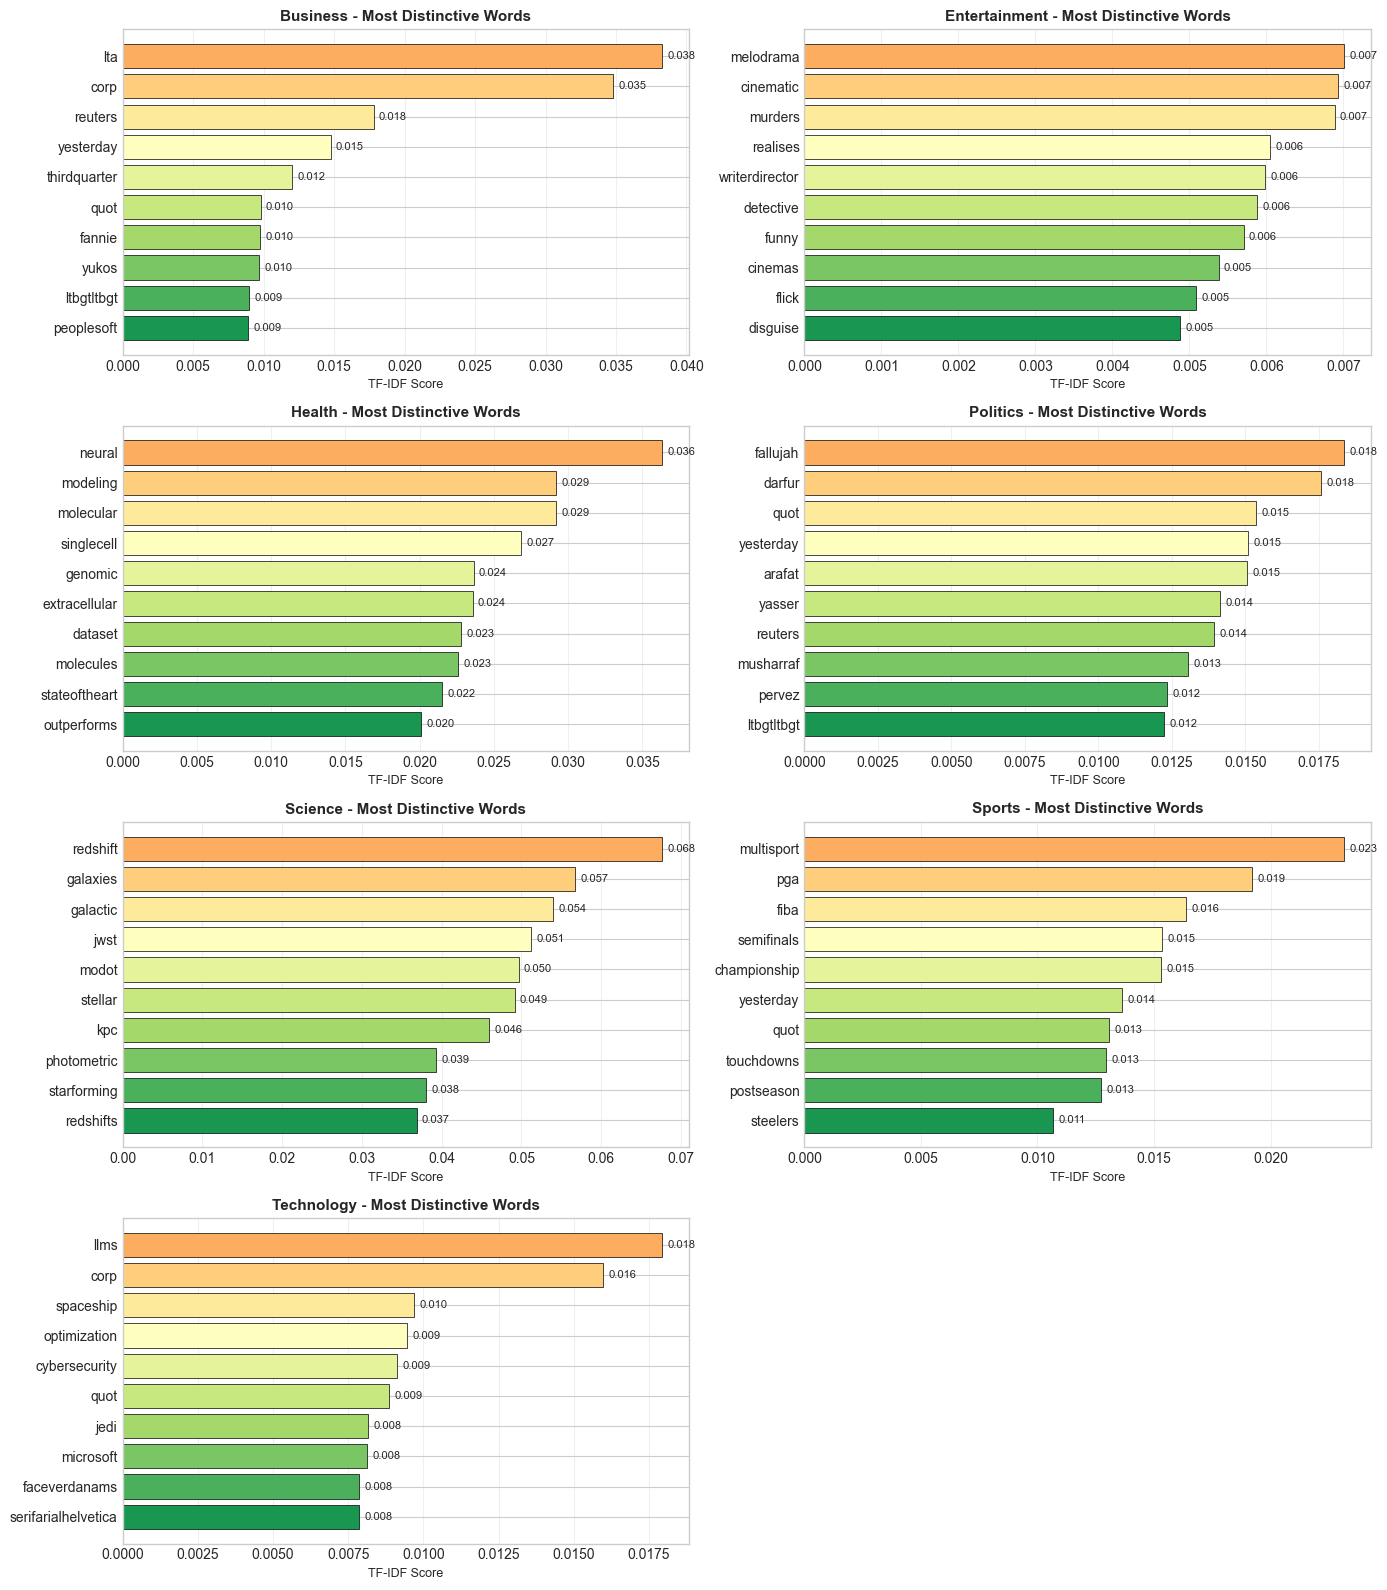

✓ Distinctive words visualizations saved


In [16]:
# Visualization - distinctive words comparison

print("\n[3] Generating distinctive words visualizations...")

# create comparative bar chart of distinctive words across topics
topics = sorted(df['unified_topic'].unique())
n_topics = len(topics)
n_cols = 2
n_rows = (n_topics + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4*n_rows))
axes = axes.flatten()

for idx, topic in enumerate(topics):
    ax = axes[idx]

    # get distinctive words and scores
    words, scores = zip(*distinctive_words[topic])

    # create gradient colors based on scores
    colors_gradient = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(words)))

    ax.barh(range(len(words)), scores, color=colors_gradient, edgecolor='black', linewidth=0.5)
    ax.set_yticks(range(len(words)))
    ax.set_yticklabels(words)
    ax.invert_yaxis()
    ax.set_title(f'{topic} - Most Distinctive Words', fontsize=11, fontweight='bold')
    ax.set_xlabel('TF-IDF Score', fontsize=9)
    ax.grid(axis='x', alpha=0.3)

    # add score labels
    for i, score in enumerate(scores):
        ax.text(score + max(scores)*0.01, i, f'{score:.3f}', va='center', fontsize=8)

# hide extra subplots if odd number of topics
for idx in range(n_topics, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('../results/01_dataset/08_topic_distinctive_words.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Distinctive words visualizations saved")


[4] Generating word clouds...


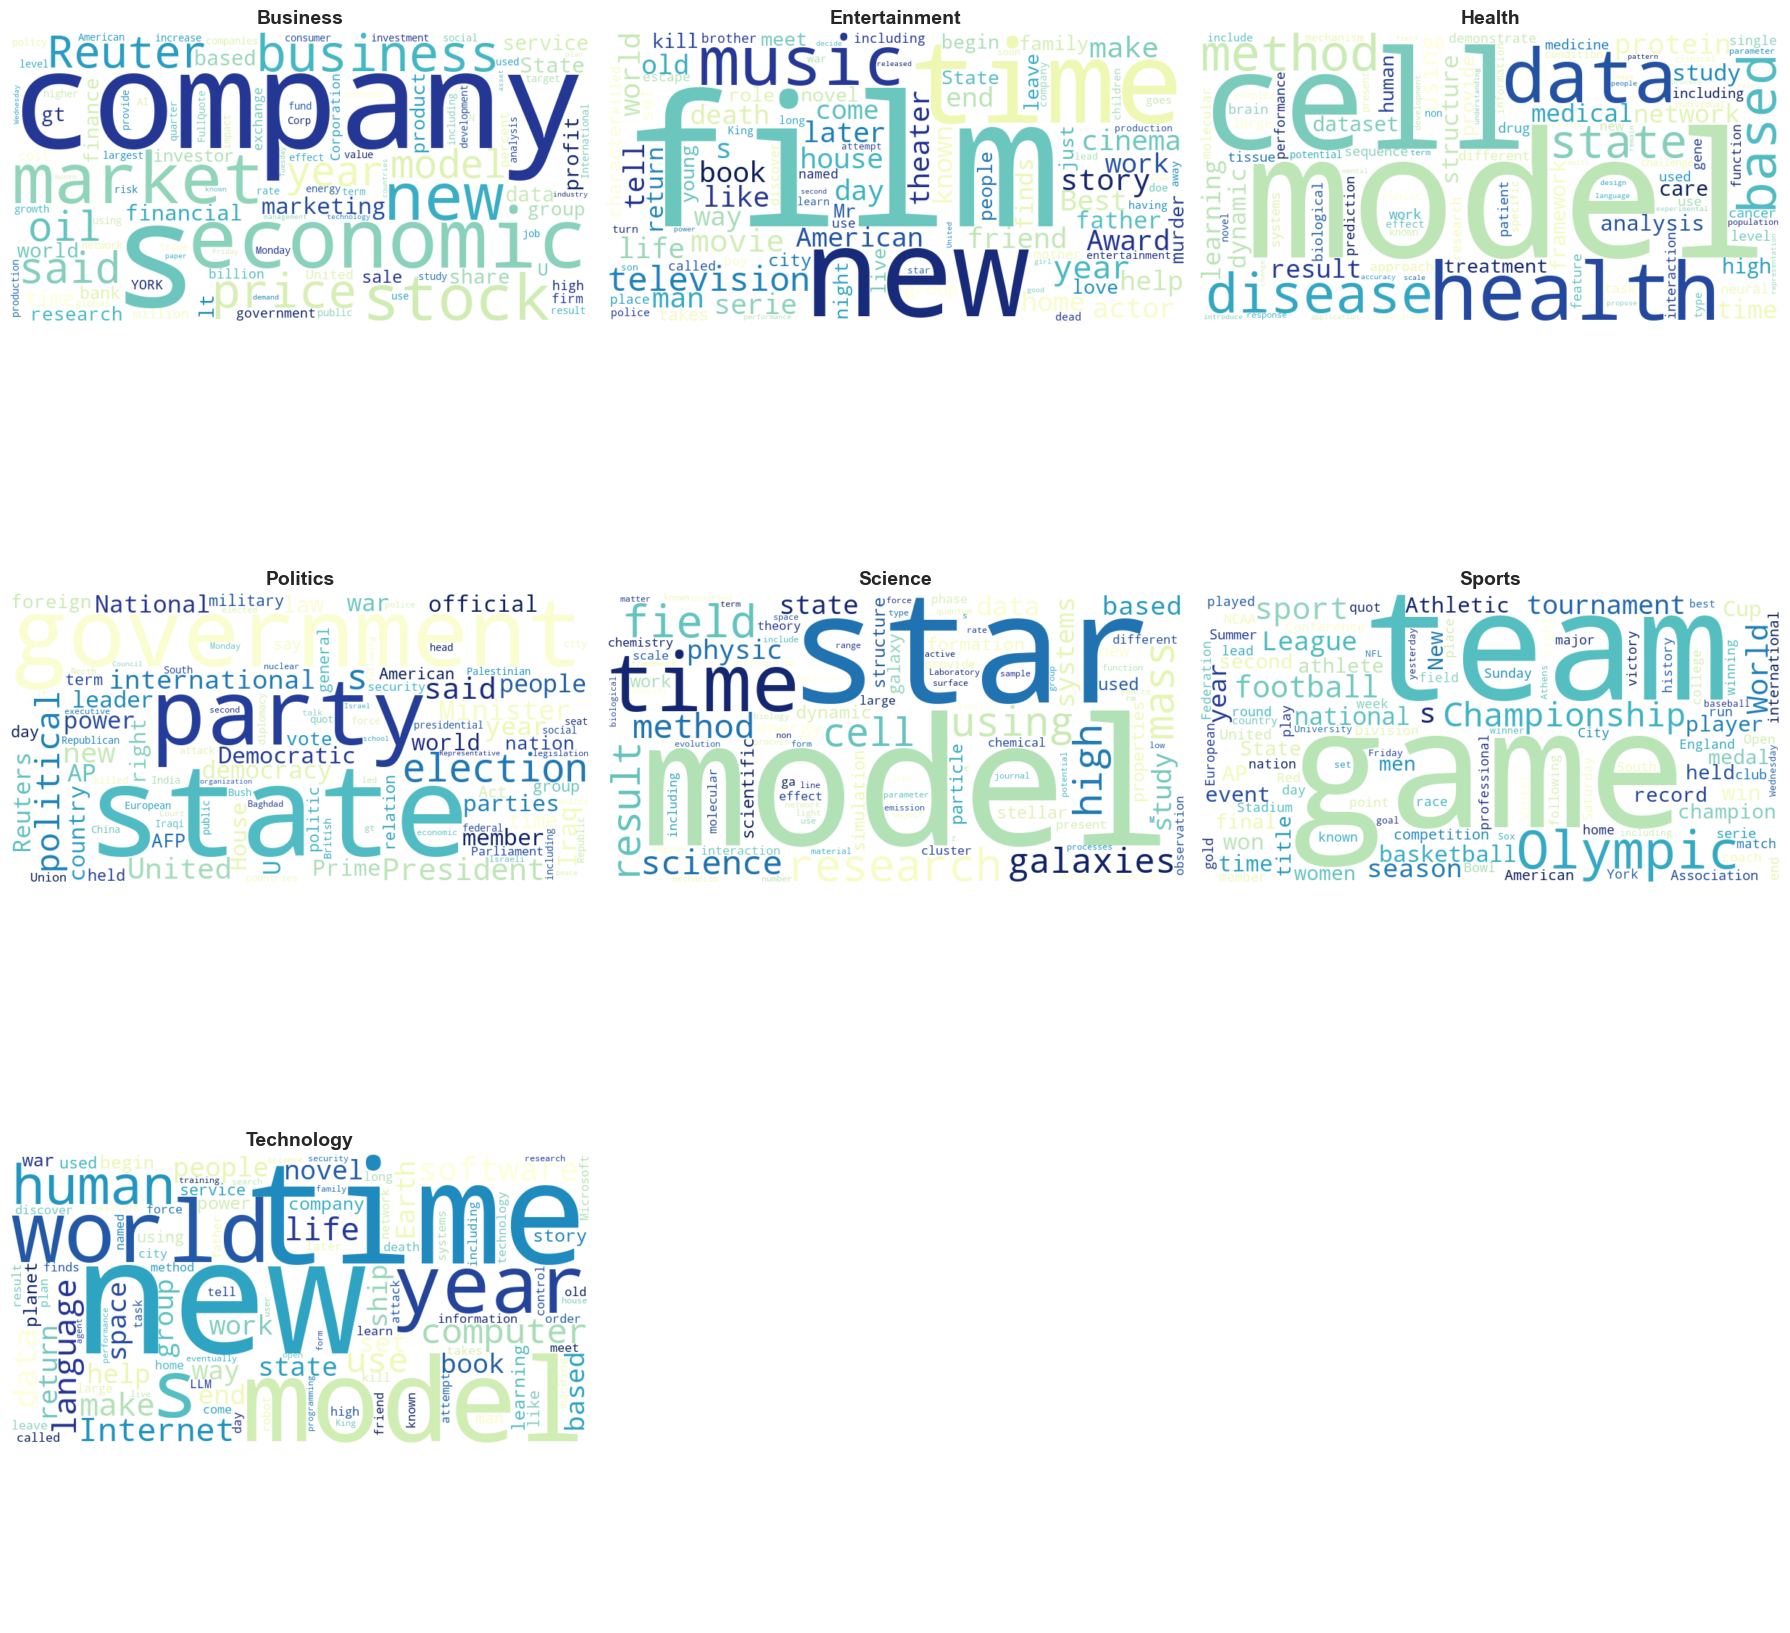

✓ Word cloud visualizations saved


In [17]:
# Visualization - word cloud

print("\n[4] Generating word clouds...")

# create word clouds for all topics
n_cols = 3
n_rows = (n_topics + 2) // 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
axes = axes.flatten()

for idx, topic in enumerate(sorted(df['unified_topic'].unique())):
    ax = axes[idx]

    # combine all texts from this topic
    topic_texts = df[df['unified_topic'] == topic]['content']
    topic_text = ' '.join(topic_texts.values)

    # generate word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='YlGnBu',
        max_words=100,
        relative_scaling=0.5,
        min_font_size=10,
        stopwords=ENGLISH_STOP_WORDS,
        collocations=False
    ).generate(topic_text)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'{topic}', fontsize=14, fontweight='bold')
    ax.axis('off')

# Hide extra subplots if needed
for idx in range(n_topics, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('../results/01_dataset/09_topic_wordclouds.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Word cloud visualizations saved")

In [18]:
# topic separability calculations

print("\n" + "="*70)
print("[5] Topic Separability Assessment")
print("="*70)


# calculate vocabulary overlap between topics
print("\nVocabulary Overlap Matrix (Jaccard Similarity):")
print("(Higher = more similar vocabulary, harder to separate)\n")

topics_list = sorted(df['unified_topic'].unique())
overlap_matrix = np.zeros((len(topics_list), len(topics_list)))


# build vocabulary sets for each topic
topic_vocab_sets = {}
for topic in topics_list:
    topic_texts = df[df['unified_topic'] == topic]['content']
    topic_words = set()
    for text in topic_texts:
        topic_words.update(extract_words_clean(text))
    topic_vocab_sets[topic] = topic_words


# calculate Jaccard similarity between all topic pairs
for i, topic1 in enumerate(topics_list):
    for j, topic2 in enumerate(topics_list):
        if i == j:
            overlap_matrix[i][j] = 1.0
        else:
            intersection = len(topic_vocab_sets[topic1] & topic_vocab_sets[topic2])
            union = len(topic_vocab_sets[topic1] | topic_vocab_sets[topic2])
            jaccard = intersection / union if union > 0 else 0
            overlap_matrix[i][j] = jaccard


# create DF for better display
overlap_df = pd.DataFrame(overlap_matrix, index=topics_list, columns=topics_list)
overlap_df = overlap_df.round(3)
print(overlap_df)


# identify most and least similar topic pairs
print("\n[6] Most Similar Topic Pairs (potential confusion):")
similarities = []
for i, topic1 in enumerate(topics_list):
    for j, topic2 in enumerate(topics_list):
        if i < j:
            similarities.append((topic1, topic2, overlap_matrix[i][j]))

similarities.sort(key=lambda x: x[2], reverse=True)

for rank, (t1, t2, sim) in enumerate(similarities[:5], 1):
    print(f"    {rank}. {t1:<15} ↔ {t2:<15} (similarity: {sim:.3f})")

print("\n[7] Most Distinct Topic Pairs (easy to separate):")
for rank, (t1, t2, sim) in enumerate(sorted(similarities, key=lambda x: x[2])[:5], 1):
    print(f"    {rank}. {t1:<15} ↔ {t2:<15} (similarity: {sim:.3f})")


[5] Topic Separability Assessment

Vocabulary Overlap Matrix (Jaccard Similarity):
(Higher = more similar vocabulary, harder to separate)

               Business  Entertainment  Health  Politics  Science  Sports  \
Business          1.000          0.217   0.224     0.276    0.218   0.238   
Entertainment     0.217          1.000   0.180     0.238    0.175   0.208   
Health            0.224          0.180   1.000     0.205    0.260   0.174   
Politics          0.276          0.238   0.205     1.000    0.200   0.265   
Science           0.218          0.175   0.260     0.200    1.000   0.176   
Sports            0.238          0.208   0.174     0.265    0.176   1.000   
Technology        0.211          0.275   0.193     0.209    0.183   0.170   

               Technology  
Business            0.211  
Entertainment       0.275  
Health              0.193  
Politics            0.209  
Science             0.183  
Sports              0.170  
Technology          1.000  

[6] Most Similar T

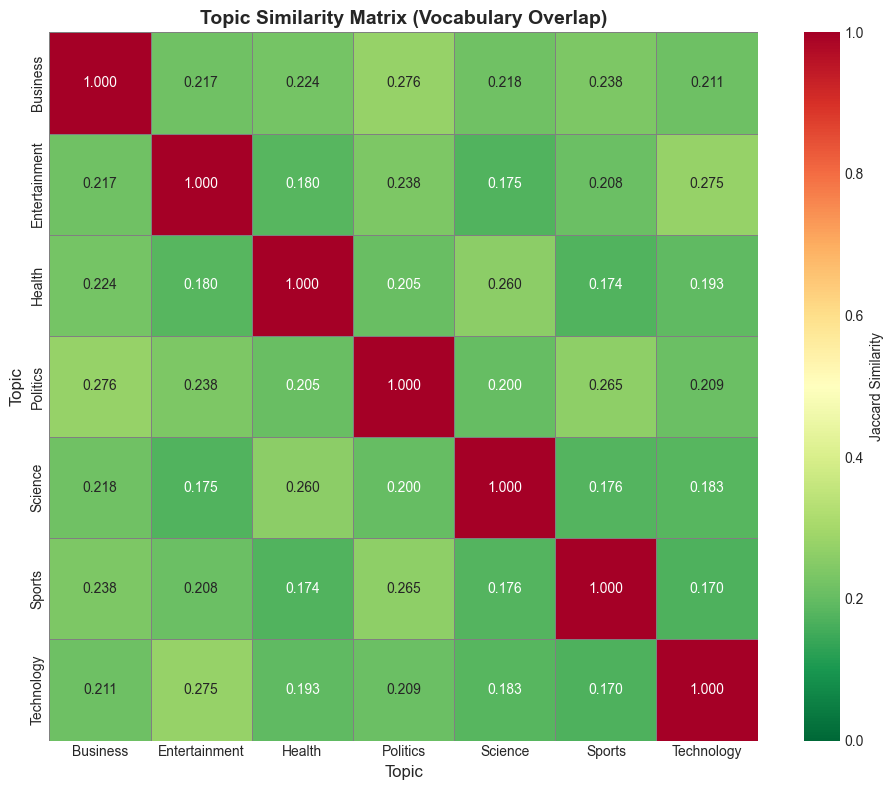


✓ Topic similarity heatmap saved


In [19]:
# Visualization - topic separability analysis

# graph config
fig, ax = plt.subplots(1, 1, figsize=(10, 8))


# create heatmap
sns.heatmap(
    overlap_df,
    annot=True,
    fmt='.3f',
    cmap='RdYlGn_r',
    vmin=0,
    vmax=1,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Jaccard Similarity'},
    ax=ax,
    square=True
)

ax.set_title('Topic Similarity Matrix (Vocabulary Overlap)', fontsize=14, fontweight='bold')
ax.set_xlabel('Topic', fontsize=12)
ax.set_ylabel('Topic', fontsize=12)

plt.tight_layout()
plt.savefig('../results/01_dataset/10_topic_similarity_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Topic similarity heatmap saved")